**STEP 1**

Framework for Single Machine Scheduling with Alternative Objectives 🐾


In [ ]:
from google.colab import files
import pandas as pd

# Upload an Excel file
uploaded = files.upload()

Saving input_439.xlsx to input_439 (2).xlsx


In [ ]:
# Read the uploaded Excel file into a DataFrame
df = pd.read_excel("input_439.xlsx")
df

,job_number,process_time,due_date,weight,release
0,1,10,4,14,0
1,2,10,2,12,0
2,3,13,1,1,0
3,4,4,12,12,0
4,5,2,22,1,0
5,6,6,12,5,0
6,7,8,10,2,0
7,8,10,5,10,0


In [ ]:
from ipywidgets import widgets
from IPython.display import display

# Define the SingleMachineScheduler class
class SingleMachineScheduler:
    def __init__(self, data):
        self.data = data

    def calculate_completion_times(self):
        # Calculate completion times based on the current order of jobs
        completion_time = 0
        completion_times = []

        for _, row in self.data.iterrows():
            # Start after the release time if completion_time is earlier
            completion_time = max(completion_time, row['release']) + row['process_time']
            completion_times.append(completion_time)

        self.data['completion_time'] = completion_times

    def evaluate_objective(self, objective_code):
        self.calculate_completion_times()  # Ensure completion times are calculated

        objectives = {
            "M": self.data['completion_time'].max(),  # Makespan
            "TCT": self.data['completion_time'].sum(),  # Total completion time
            "TT": ((self.data['completion_time'] - self.data['due_date']).clip(lower=0)).sum(),  # Total tardiness
            "TWCT": (self.data['weight'] * self.data['completion_time']).sum(),  # Total weighted completion time
            "ML": (self.data['completion_time'] - self.data['due_date']).max(),  # Maximum lateness
            "TWT": (self.data['weight'] * ((self.data['completion_time'] - self.data['due_date']).clip(lower=0))).sum(),  # Total weighted tardiness
            "TLJ": ((self.data['completion_time'] - self.data['due_date']) > 0).sum(),  # Total number of late jobs
            "TWLJ": self.data.loc[(self.data['completion_time'] - self.data['due_date']) > 0, 'weight'].sum()  # Total weighted number of late jobs
        }

        if objective_code in objectives:
            return objectives[objective_code]
        else:
            raise AttributeError(f"Objective code '{objective_code}' is not valid.")

    def apply_custom_sequence(self, sequence):
        # Reorder jobs according to the given sequence
        self.data = self.data.loc[sequence].reset_index(drop=True)

# Instantiate the scheduler with the provided DataFrame `df`
# Replace this with your actual DataFrame
scheduler = SingleMachineScheduler(df)

# Function to evaluate and display the selected objective
def evaluate_objective(change):
    objective_code = text_input.value.strip().upper()  # Convert input to uppercase

    try:
        result = scheduler.evaluate_objective(objective_code)
        print(f"Objective '{objective_code}': {result}")
    except AttributeError:
        print(f"Error: '{objective_code}' is not a valid objective code.")

# Function to apply a custom sequence
def apply_sequence(change):
    try:
        sequence = list(map(int, sequence_input.value.split(',')))  # Parse sequence input
        scheduler.apply_custom_sequence(sequence)
        print(f"Custom sequence applied: {sequence}")
    except Exception as e:
        print(f"Error: {e}")

# Create widgets
text_input = widgets.Text(
    description="Objective:",
    placeholder="Enter code (e.g., M for Makespan)"
)
sequence_input = widgets.Text(
    description="Sequence:",
    placeholder="Enter custom sequence (e.g., 3,2,1,4)"
)

# Add event listeners
text_input.on_submit(evaluate_objective)
sequence_input.on_submit(apply_sequence)

# Display widgets
display(sequence_input)
display(text_input)

# List of objectives with their codes
objective_codes = {
    "M": "Makespan",
    "TCT": "Total Completion Time",
    "TT": "Total Tardiness",
    "TWCT": "Total Weighted Completion Time",
    "ML": "Maximum Lateness",
    "TWT": "Total Weighted Tardiness",
    "TLJ": "Total Number of Late Jobs",
    "TWLJ": "Total Weighted Number of Late Jobs"
}

print("Objective Codes:")
for code, name in objective_codes.items():
    print(f"{code}: {name}")


Text(value='', description='Sequence:', placeholder='Enter custom sequence (e.g., 3,2,1,4)')

Text(value='', description='Objective:', placeholder='Enter code (e.g., M for Makespan)')

Objective Codes:
M: Makespan
TCT: Total Completion Time
TT: Total Tardiness
TWCT: Total Weighted Completion Time
ML: Maximum Lateness
TWT: Total Weighted Tardiness
TLJ: Total Number of Late Jobs
TWLJ: Total Weighted Number of Late Jobs


**STEP 2**

Gantt Chart Generator 🦙

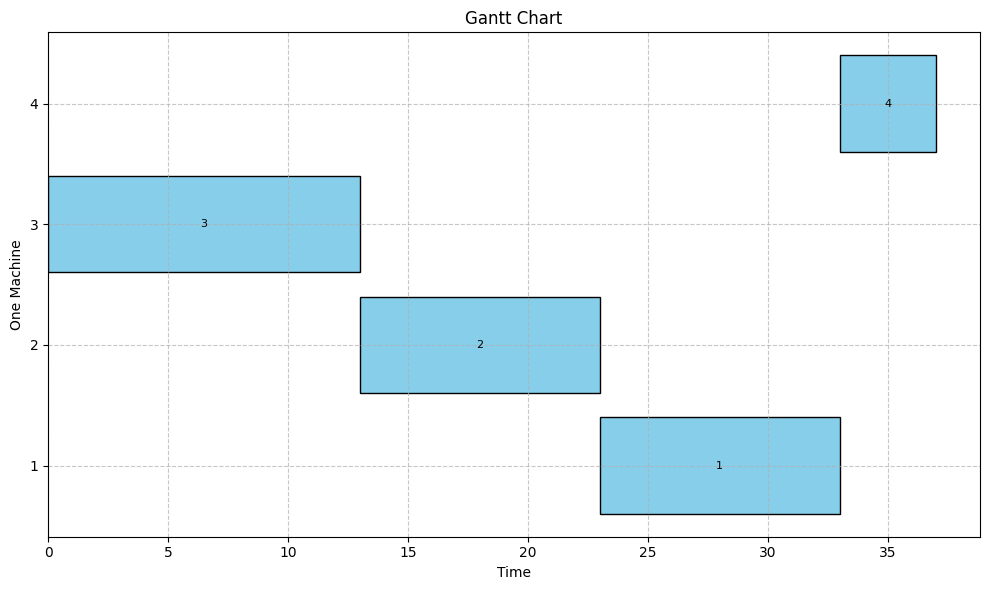

In [ ]:
import matplotlib.pyplot as plt

def generate_gantt_chart(scheduler, sequence=None):
    """
    Generates a Gantt chart for the scheduler. If a sequence is provided,
    it reorders the jobs before generating the chart.

    Args:
        scheduler: Instance of SingleMachineScheduler.
        sequence (list): Custom job sequence as a list of job numbers.
    """
    # Map job numbers to indices and apply the sequence
    if sequence is not None:
        try:
            # Map job numbers to indices based on the 'job_number' column
            sequence_indices = scheduler.data[scheduler.data['job_number'].isin(sequence)].index.tolist()
            sequence_order = [scheduler.data[scheduler.data['job_number'] == job].index[0] for job in sequence]
            scheduler.apply_custom_sequence(sequence_order)
        except KeyError as e:
            print(f"Error: {e}. Ensure job numbers exist in the dataset.")
            return

    # Ensure the scheduler has calculated completion times
    scheduler.calculate_completion_times()

    # Extract relevant data from the scheduler
    data = scheduler.data

    # Create a Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))

    for _, row in data.iterrows():
        start_time = max(row['release'], row['completion_time'] - row['process_time'])
        ax.barh(int(row['job_number']), row['process_time'], left=start_time, color='skyblue', edgecolor='black')
        ax.text(start_time + row['process_time'] / 2, int(row['job_number']), str(int(row['job_number'])),
                ha='center', va='center', color='black', fontsize=8)

    # Label and customize the chart
    ax.set_xlabel('Time')
    ax.set_ylabel('One Machine', rotation=90)  # Set y-axis label with rotation
    ax.set_title('Gantt Chart')
    ax.set_yticks(data['job_number'].astype(int))  # Ensure y-axis labels are integers
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage with a custom sequence
custom_sequence = [3, 2, 1, 4]  # Replace with your desired sequence of job numbers
generate_gantt_chart(scheduler, sequence=custom_sequence)


**STEP 3**

Application of Dispatching Rules 🐑

In [ ]:
pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [ ]:
import pandas as pd

# Assuming df is already read from your Excel file and contains job_number, process_time, due_date, weight, and release
def schedule_jobs(df, sort_column, ascending=True):
    # Sort the DataFrame based on the specified column
    sorted_df = df.sort_values(by=sort_column, ascending=ascending)

    # Calculate start times based on release and previous job's finish time
    start_times = [sorted_df.iloc[0]['release']]
    for i in range(1, len(sorted_df)):
        start_time = max(sorted_df.iloc[i]['release'], start_times[-1] + sorted_df.iloc[i-1]['process_time'])
        start_times.append(start_time)

    # Assign start and finish times to the DataFrame
    sorted_df['start'] = start_times
    sorted_df['finish'] = sorted_df['start'] + sorted_df['process_time']
    return sorted_df

def spt(df):
    return schedule_jobs(df, 'process_time')

def wspt(df):
    df['wspt'] = df['process_time'] / df['weight']
    return schedule_jobs(df, 'wspt')

def edd(df):
    return schedule_jobs(df, 'due_date')

def erd(df):
    return schedule_jobs(df, 'release')

def lpt(df):
    return schedule_jobs(df, 'process_time', ascending=False)


In [ ]:
import plotly.graph_objects as go

def create_gantt(df, title='Gantt Chart'):
    # Initialize a figure for the Gantt chart
    fig = go.Figure()

    # Generate a unique color for each job
    colors = [
    "rgba(255, 0, 0, 0.7)",  # Red
    "rgba(0, 255, 0, 0.7)",  # Green
    "rgba(0, 0, 255, 0.7)",  # Blue
    "rgba(128, 0, 128, 0.7)"  # Purple
] * (len(df) // 4 + 1)

    # Add each job as a separate bar on the Gantt chart
    for i, row in df.iterrows():
        fig.add_trace(go.Bar(
            x=[row['finish'] - row['start']],  # Duration
            y=["One Machine"],  # Job ID as label
            base=row['start'],  # Starting point on the x-axis
            orientation='h',  # Horizontal bar
            text=(f"Job ID: {row['job_number']}<br>"
                  f"Start: {row['start']}<br>"
                  f"Finish: {row['finish']}<br>"
                  f"Processing Time: {row['process_time']}<br>"
                  f"Due Date: {row['due_date']}<br>"
                  f"Weight: {row['weight']}"),
            hoverinfo='text',
            marker=dict(color=colors[i])  # Assign a unique color
        ))

    # Update the layout for better clarity
    fig.update_layout(
        title=title,
        xaxis_title="Time Units",
        yaxis_title="Jobs",
        xaxis=dict(showgrid=True, zeroline=False, range=[0, df['finish'].max() + 10]),
        yaxis=dict(showgrid=True),
        barmode='stack'
    )
    return fig


In [ ]:
import dash
from dash import html, dcc
from dash.dependencies import Input, Output

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(
        id='rule-selector',
        options=[
            {'label': 'Shortest Processing Time (SPT)', 'value': 'SPT'},
            {'label': 'Weighted Shortest Processing Time (WSPT)', 'value': 'WSPT'},
            {'label': 'Earliest Due Date (EDD)', 'value': 'EDD'},
            {'label': 'Earliest Release Date (ERD)', 'value': 'ERD'},
            {'label': 'Longest Processing Time (LPT)', 'value': 'LPT'}
        ],
        value='SPT'
    ),
    dcc.Graph(id='gantt-chart')
])

@app.callback(
    Output('gantt-chart', 'figure'),
    Input('rule-selector', 'value')
)
def update_chart(selected_rule):
    if selected_rule == 'SPT':
        sorted_df = spt(df)
    elif selected_rule == 'WSPT':
        sorted_df = wspt(df)
    elif selected_rule == 'EDD':
        sorted_df = edd(df)
    elif selected_rule == 'ERD':
        sorted_df = erd(df)
    elif selected_rule == 'LPT':
        sorted_df = lpt(df)
    return create_gantt(sorted_df, title=f"Gantt Chart - {selected_rule}")

if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

**STEP 4**

Application of Scheduling Rules for Parallel Machines 🐻

BoundedIntText(value=2, description='Machines:', min=1)

Dropdown(description='Rule:', options=('SPT', 'LPT', 'Wrap-Around'), value='SPT')

Button(description='Schedule', style=ButtonStyle())

Rule: Wrap-Around
Number of Machines: 4
Objectives:
- makespan: 21
- total_completion_time: 63


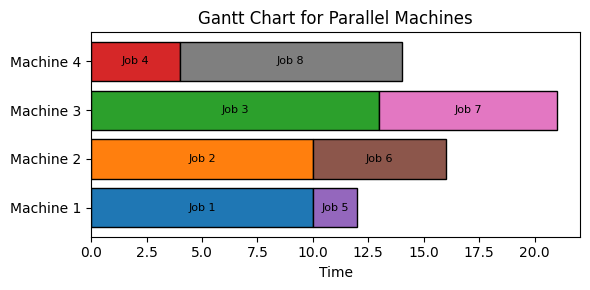

Rule: Wrap-Around
Number of Machines: 6
Objectives:
- makespan: 20
- total_completion_time: 63


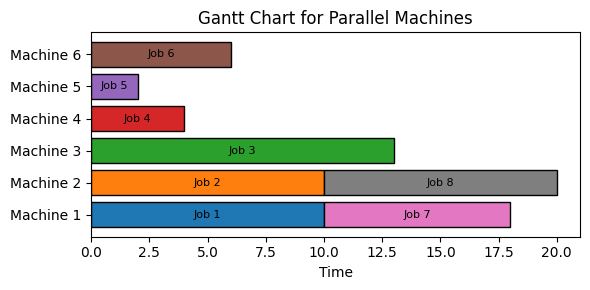

Rule: SPT
Number of Machines: 6
Objectives:
- makespan: 17
- total_completion_time: 63


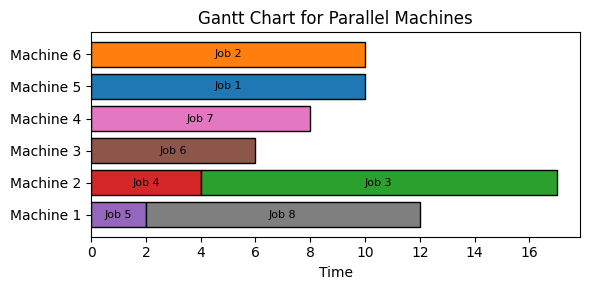

In [ ]:
from ipywidgets import widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Parallel Machine Scheduler Class
class ParallelMachineScheduler:
    def __init__(self, data, num_machines):
        self.data = data.copy()
        self.num_machines = num_machines
        self.machines = {i: [] for i in range(1, num_machines + 1)}
        self.machine_completion_times = {i: 0 for i in range(1, num_machines + 1)}

    def assign_jobs(self, rule="SPT"):
        # Sort jobs based on the rule
        if rule == "SPT":
            sorted_jobs = self.data.sort_values(by="process_time").reset_index(drop=True)
        elif rule == "LPT":
            sorted_jobs = self.data.sort_values(by="process_time", ascending=False).reset_index(drop=True)
        elif rule == "Wrap-Around":
            sorted_jobs = self.data.copy()  # No sorting for wrap-around rule
        else:
            raise ValueError(f"Unknown scheduling rule: {rule}")

        # Clear machines and completion times
        self.machines = {i: [] for i in range(1, self.num_machines + 1)}
        self.machine_completion_times = {i: 0 for i in range(1, self.num_machines + 1)}

        # Assign jobs to machines
        for idx, row in sorted_jobs.iterrows():
            if rule == "Wrap-Around":
                machine = (idx % self.num_machines) + 1
            else:
                # Find the machine with the least current completion time
                machine = min(self.machine_completion_times, key=self.machine_completion_times.get)

            # Assign the job to the selected machine
            self.machines[machine].append(row["job_number"])
            self.machine_completion_times[machine] += row["process_time"]

    def calculate_objectives(self):
        makespan = max(self.machine_completion_times.values())
        total_completion_time = sum(self.machine_completion_times.values())
        return {"makespan": makespan, "total_completion_time": total_completion_time}

    def generate_gantt_chart(self):
        # Create Gantt chart
        fig, ax = plt.subplots(figsize=(6, 3))

        # Generate unique colors for each job
        unique_colors = list(mcolors.TABLEAU_COLORS.values())  # A list of distinct colors
        job_colors = {job: unique_colors[idx % len(unique_colors)] for idx, job in enumerate(self.data['job_number'])}

        # Create bars for each job on the assigned machine
        for machine, jobs in self.machines.items():
            current_time = 0
            for job in jobs:
                job_row = self.data.loc[self.data["job_number"] == job]
                process_time = job_row["process_time"].values[0]
                ax.barh(machine, process_time, left=current_time, color=job_colors[job], edgecolor='black')
                ax.text(
                    current_time + process_time / 2, machine,
                    f"Job {int(job)}", ha='center', va='center', fontsize=8, color='black'
                )
                current_time += process_time

        # Customize chart
        ax.set_yticks(list(self.machines.keys()))
        ax.set_yticklabels([f"Machine {i}" for i in self.machines.keys()])
        ax.set_xlabel("Time")
        ax.set_title("Gantt Chart for Parallel Machines")
        plt.tight_layout()
        plt.show()

# Input Widget for Number of Machines and Rule
num_machines_input = widgets.BoundedIntText(description="Machines:", value=2, min=1, max=100)
rule_input = widgets.Dropdown(
    options=["SPT", "LPT", "Wrap-Around"],
    description="Rule:"
)
submit_button = widgets.Button(description="Schedule")

# Function to run the scheduling process
def run_scheduler(_):
    num_machines = num_machines_input.value
    rule = rule_input.value

    # Validate machine number
    if num_machines <= 0:
        print("Error: Number of machines must be greater than 0.")
        return

    # Use the existing DataFrame df
    global df
    scheduler = ParallelMachineScheduler(df, num_machines)
    scheduler.assign_jobs(rule=rule)
    objectives = scheduler.calculate_objectives()

    # Display Results
    print(f"Rule: {rule}")
    print(f"Number of Machines: {num_machines}")
    print("Objectives:")
    for key, value in objectives.items():
        print(f"- {key}: {value}")

    # Generate Gantt Chart
    scheduler.generate_gantt_chart()

# Event Listener for Button
submit_button.on_click(run_scheduler)

# Display Widgets
display(num_machines_input, rule_input, submit_button)

**STEP 5**

Application of Local Search and Meta-Heuristics for Parallel Machine and/or Flow Shop Problems 🧚🏻

single machine local search

In [ ]:
import pandas as pd
# Objective codes
objective_codes = {
    "M": "Makespan",
    "TCT": "Total Completion Time",
    "TT": "Total Tardiness",
    "TWCT": "Total Weighted Completion Time",
    "ML": "Maximum Lateness",
    "TWT": "Total Weighted Tardiness",
    "TWLJ": "Total Weighted Number of Late Jobs"
}

# Function to calculate metrics
def calculate_metrics(df):
    completion_time = 0
    completion_times = []
    tardiness = []
    weighted_completion_time = []
    weighted_tardiness = []
    late_jobs = 0
    weighted_late_jobs = 0

    for _, row in df.iterrows():
        completion_time = max(completion_time, row['release']) + row['process_time']
        completion_times.append(completion_time)
        tardiness_value = max(0, completion_time - row['due_date'])
        tardiness.append(tardiness_value)
        weighted_completion_time.append(row['weight'] * completion_time)
        weighted_tardiness.append(row['weight'] * tardiness_value)
        if tardiness_value > 0:
            late_jobs += 1
            weighted_late_jobs += row['weight']

    df['completion_time'] = completion_times
    df['tardiness'] = tardiness
    df['weighted_completion_time'] = weighted_completion_time

    return {
        "M": max(completion_times),
        "TCT": sum(completion_times),
        "TT": sum(tardiness),
        "TWCT": sum(weighted_completion_time),
        "ML": max(completion_times) - min(df['due_date']),
        "TWT": sum(weighted_tardiness),
        "TLJ": late_jobs,
        "TWLJ": weighted_late_jobs
    }

# Perform adjacent swaps and evaluate
initial_sequence = [2, 3, 4, 1]
def local_search(initial_sequence, objective):
    current_sequence = initial_sequence.copy()
    reordered_df = df.set_index('job_number').loc[current_sequence].reset_index()
    initial_metrics = calculate_metrics(reordered_df)
    print(f"Initial Solution: {current_sequence} -> {objective}: {initial_metrics[objective]}")

    best_value = initial_metrics[objective]
    improved = True

    while improved:
        improved = False
        best_neighbor = None

        for i in range(len(current_sequence) - 1):
            neighbor = current_sequence.copy()
            neighbor[i], neighbor[i + 1] = neighbor[i + 1], neighbor[i]

            # Apply the new sequence
            reordered_df = df.set_index('job_number').loc[neighbor].reset_index()
            metrics = calculate_metrics(reordered_df)

            print(f"Sequence: {neighbor} -> {objective}: {metrics[objective]}")

            if metrics[objective] < best_value:
                best_value = metrics[objective]
                best_neighbor = neighbor
                improved = True

        if improved:
            current_sequence = best_neighbor
            print(f"Accepted Sequence: {current_sequence} -> {objective}: {best_value}")
        else:
            print("No improvement found. Stopping.")

    return current_sequence

# Select an objective
while True:
    objective = input(f"Select an objective ({', '.join(objective_codes.keys())}): ").strip().upper()
    if objective in objective_codes:
        break
    else:
        print("Invalid objective code. Please try again.")

print(f"Initial Sequence: {initial_sequence}")
best_sequence = local_search(initial_sequence, objective)
print(f"Best Sequence: {best_sequence}")


Select an objective (M, TCT, TT, TWCT, ML, TWT, TWLJ): TCT
Initial Sequence: [2, 3, 4, 1]
Initial Solution: [2, 3, 4, 1] -> TCT: 97
Sequence: [3, 2, 4, 1] -> TCT: 100
Sequence: [2, 4, 3, 1] -> TCT: 88
Sequence: [2, 3, 1, 4] -> TCT: 103
Accepted Sequence: [2, 4, 3, 1] -> TCT: 88
Sequence: [4, 2, 3, 1] -> TCT: 82
Sequence: [2, 3, 4, 1] -> TCT: 97
Sequence: [2, 4, 1, 3] -> TCT: 85
Accepted Sequence: [4, 2, 3, 1] -> TCT: 82
Sequence: [2, 4, 3, 1] -> TCT: 88
Sequence: [4, 3, 2, 1] -> TCT: 85
Sequence: [4, 2, 1, 3] -> TCT: 79
Accepted Sequence: [4, 2, 1, 3] -> TCT: 79
Sequence: [2, 4, 1, 3] -> TCT: 85
Sequence: [4, 1, 2, 3] -> TCT: 79
Sequence: [4, 2, 3, 1] -> TCT: 82
No improvement found. Stopping.
Best Sequence: [4, 2, 1, 3]


parallel machine - local search with insert

In [ ]:
import pandas as pd
import numpy as np
import random

# Load data from Excel
# Ensure the Excel file contains required columns: 'job_number', 'release', 'process_time', 'due_date', 'weight'
df = pd.read_excel("input_439.xlsx")
df.set_index('job_number', inplace=True)

# Objective codes
objective_codes = {
    "M": "Makespan",
    "TCT": "Total Completion Time",
    "TT": "Total Tardiness",
    "TWCT": "Total Weighted Completion Time",
    "ML": "Maximum Lateness",
    "TWT": "Total Weighted Tardiness",
    "TLJ": "Total Number of Late Jobs",
    "TWLJ": "Total Weighted Number of Late Jobs"
}

# Function to calculate metrics for parallel machines using wrap-around assignment
def calculate_parallel_metrics_wrap_around(sequence, num_machines):
    machine_jobs = [[] for _ in range(num_machines)]
    machine_completion_times = [0] * num_machines

    for i, job in enumerate(sequence):
        machine_index = i % num_machines  # Wrap-around assignment
        machine_jobs[machine_index].append(job)
        process_time = df.loc[job, 'process_time']
        machine_completion_times[machine_index] += process_time

    tardiness = []
    weighted_completion_time = []
    weighted_tardiness = []
    late_jobs = 0
    weighted_late_jobs = 0

    for machine_index, jobs in enumerate(machine_jobs):
        completion_time = 0
        for job in jobs:
            row = df.loc[job]
            start_time = max(completion_time, row['release'])
            completion_time = start_time + row['process_time']
            tardiness_value = max(0, completion_time - row['due_date'])
            tardiness.append(tardiness_value)
            weighted_completion_time.append(row['weight'] * completion_time)
            weighted_tardiness.append(row['weight'] * tardiness_value)

            if tardiness_value > 0:
                late_jobs += 1
                weighted_late_jobs += row['weight']

    makespan = max(machine_completion_times)
    total_completion_time = sum(machine_completion_times)

    return {
        "M": makespan,
        "TCT": total_completion_time,
        "TT": sum(tardiness),
        "TWCT": sum(weighted_completion_time),
        "ML": max(tardiness),
        "TWT": sum(weighted_tardiness),
        "TLJ": late_jobs,
        "TWLJ": weighted_late_jobs
    }, machine_jobs

# Perform local search using insert-based neighborhood generation
def local_search_parallel_insert(num_jobs, num_machines, initial_sequence, objective):
    # Initial solution
    initial_metrics, initial_jobs = calculate_parallel_metrics_wrap_around(initial_sequence, num_machines)
    print(f"Initial Machine Assignments: {initial_jobs}\n")
    print(f"Initial Solution -> {objective}: {initial_metrics[objective]}\n")

    current_sequence = initial_sequence.copy()
    best_value = initial_metrics[objective]
    improved = True

    while improved:
        improved = False
        best_neighbor = None
        best_jobs = None

        for i in range(len(current_sequence)):
            for j in range(len(current_sequence)):
                if i != j:
                    # Generate neighbor by removing and reinserting the job
                    neighbor = current_sequence.copy()
                    job = neighbor.pop(i)
                    neighbor.insert(j, job)

                    # Calculate metrics for the neighbor
                    metrics, jobs = calculate_parallel_metrics_wrap_around(neighbor, num_machines)

                    print(f"Neighbor Machine Assignments: {jobs}")
                    print(f"Sequence: {neighbor} -> {objective}: {metrics[objective]}")
                    best_value = 5
                    if metrics[objective] + best_value < best_value:
                        best_value = metrics[objective]
                        best_neighbor = neighbor
                        best_jobs = jobs
                        improved = True
                        print("Sequence Accepted.\n")
                    else:
                        print("Sequence Rejected.\n")

        if improved:
            current_sequence = best_neighbor
            print(f"Accepted Machine Assignments: {best_jobs}\n")
            print(f"Accepted Sequence: {current_sequence} -> {objective}: {best_value}\n")
        else:
            print("No improvement found. Stopping.\n")

    return current_sequence

# Select an objective and number of machines
while True:
    objective = input(f"Select an objective ({', '.join(objective_codes.keys())}): ").strip().upper()
    if objective in objective_codes:
        break
    else:
        print("Invalid objective code. Please try again.")

num_machines = int(input("Enter the number of machines: "))
num_jobs = len(df)  # Number of jobs

# Input the initial sequence
while True:
    try:
        initial_sequence = list(map(int, input("Enter the initial sequence of job numbers (comma-separated): ").split(',')))
        if len(initial_sequence) != num_jobs:
            print(f"Error: The sequence must include exactly {num_jobs} job numbers.")
            continue
        break
    except ValueError:
        print("Error: Please enter valid integers separated by commas.")

best_sequence = local_search_parallel_insert(num_jobs, num_machines, initial_sequence, objective)
print(f"Best Sequence: {best_sequence}")


Select an objective (M, TCT, TT, TWCT, ML, TWT, TLJ, TWLJ): m
Enter the number of machines: 2
Enter the initial sequence of job numbers (comma-separated): 1,2,3,4,5,6,7,8
Initial Machine Assignments: [[1, 3, 5, 7], [2, 4, 6, 8]]

Initial Solution -> M: 33

Neighbor Machine Assignments: [[2, 3, 5, 7], [1, 4, 6, 8]]
Sequence: [2, 1, 3, 4, 5, 6, 7, 8] -> M: 33
Sequence Rejected.

Neighbor Machine Assignments: [[2, 1, 5, 7], [3, 4, 6, 8]]
Sequence: [2, 3, 1, 4, 5, 6, 7, 8] -> M: 33
Sequence Rejected.

Neighbor Machine Assignments: [[2, 4, 5, 7], [3, 1, 6, 8]]
Sequence: [2, 3, 4, 1, 5, 6, 7, 8] -> M: 39
Sequence Rejected.

Neighbor Machine Assignments: [[2, 4, 1, 7], [3, 5, 6, 8]]
Sequence: [2, 3, 4, 5, 1, 6, 7, 8] -> M: 32
Sequence Rejected.

Neighbor Machine Assignments: [[2, 4, 6, 7], [3, 5, 1, 8]]
Sequence: [2, 3, 4, 5, 6, 1, 7, 8] -> M: 35
Sequence Rejected.

Neighbor Machine Assignments: [[2, 4, 6, 1], [3, 5, 7, 8]]
Sequence: [2, 3, 4, 5, 6, 7, 1, 8] -> M: 33
Sequence Rejected.

Neigh